<a href="https://colab.research.google.com/github/megha-puthukudi/main-project/blob/VGG16-SEVERE/vecicle_damage_VGG16_epoch_60_severity_new_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 1150 images belonging to 3 classes.
Found 225 images belonging to 3 classes.
Found 225 images belonging to 3 classes.
Epoch 1/200
71/71 [==============================] - 37s 512ms/step - loss: 1.0066 - accuracy: 0.4832 - val_loss: 0.8958 - val_accuracy: 0.5491
Epoch 2/200
71/71 [==============================] - 23s 316ms/step - loss: 0.8938 - accuracy: 0.5750 - val_loss: 0.8971 - val_accuracy: 0.5134
Epoch 3/200
71/71 [==============================] - 23s 326ms/step - loss: 0.8436 - accuracy: 0.5829 - val_loss: 0.8642 - val_accuracy: 0.5938
Epoch 4/200
71/71 [==============================] - 23s 325ms/step - loss: 0.7914 - accuracy: 0.6226 - val_loss: 0.8299 - val_accuracy: 0.5982
Epoch 5/200
71/71 [==============================] - 23s 330ms/step - loss: 0.7782 - accuracy: 0.6420 - val_loss: 0.8112 - val_accuracy: 0.6116
Epoch 6/200
71/71 [==============================] - 23s 321ms/step - loss: 0.7716 - accuracy: 0.6446 - val_loss: 0.8179 - val_accuracy: 0.5670
Epoch 7/200


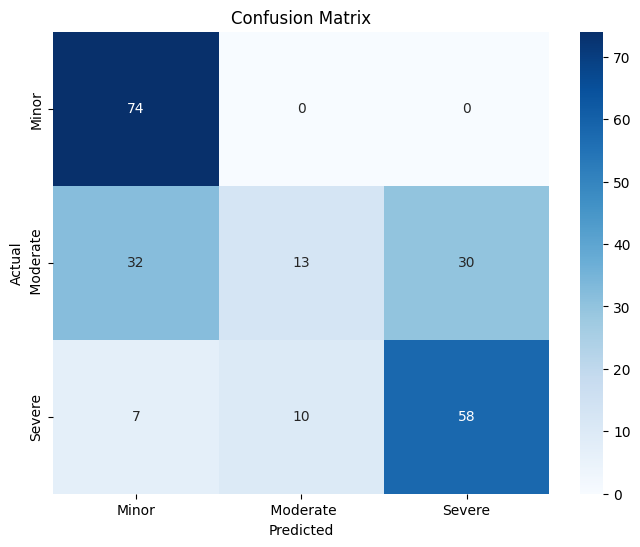

Test loss: 1.1328
Test accuracy: 65.18
Train loss: 0.3988
Train accuracy: 84.24
Recall: 0.65
Precision: 0.63
F1-score: 0.59


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16  # Import VGG16 architecture
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns

# Define your data directories
train_dir = '/content/drive/MyDrive/new datasets severe/train'
val_dir = '/content/drive/MyDrive/new datasets severe/validation'
test_dir = '/content/drive/MyDrive/new datasets severe/test'

# Define image size and batch size
img_size = (224, 224)
batch_size = 16

# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Load VGG16

# Flatten the output of VGG16
x = Flatten()(base_model.output)

# Add a fully connected layer for classification
predictions = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=200,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // batch_size)
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.n // batch_size)

# Calculate recall
y_true = []
y_pred = []
for i in range(test_generator.n // batch_size):
    batch_x, batch_y = next(test_generator)
    y_true.extend(np.argmax(batch_y, axis=1))
    y_pred.extend(np.argmax(model.predict(batch_x), axis=1))

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Minor', ' Moderate', 'Severe'], yticklabels=['Minor', ' Moderate', 'Severe'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate other metrics
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Display metrics
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy * 100:.2f}')
print(f'Train loss: {train_loss:.4f}')
print(f'Train accuracy: {train_accuracy * 100:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1-score: {f1:.2f}')

# Save the trained model
model.save('/content/drive/MyDrive/colabtest/vecicle_damage_VGG16_epoch_60_severity_new_dataset.h5')
